In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import seaborn as sns
import healpy as hp
from h5py import File


from reconstruction_comparison import *
SPEED_OF_LIGHT = 299_792.458
from csiborgtools import radec_to_galactic

%load_ext autoreload
%autoreload 2
%matplotlib inline

## Paper plots

In [2]:
with File("/mnt/extraspace/rstiskalek/catalogs/PV_compilation.hdf5", 'r') as f:
    SFI = {}
    for key in f["SFI_gals"].keys():
        SFI[key] = f["SFI_gals"][key][...]
    
    TWOMTF = {}
    for key in f["2MTF"].keys():
        TWOMTF[key] = f["2MTF"][key][...]
    
    FOUNDATION = {}
    for key in f["Foundation"].keys():
        FOUNDATION[key] = f["Foundation"][key][...]
    
    LOSS = {}
    for key in f["LOSS"].keys():
        LOSS[key] = f["LOSS"][key][...]



with File("/mnt/extraspace/rstiskalek/catalogs/PV/CF4/CF4_TF-distances.hdf5", 'r') as f:
    CF4_TFR = {}
    for key in f.keys():
        CF4_TFR[key] = f[key][...]
    
    RA = f["RA"][...] * 360 / 24
    CF4_TFR["RA"] = RA
    
    CF4_TFR["DEC"] = f["DE"][...]

    l, b = radec_to_galactic(CF4_TFR["RA"], CF4_TFR["DE"])
    m = np.abs(b) > 7.5
    for key in CF4_TFR.keys():
        CF4_TFR[key] = CF4_TFR[key][m]

### 1. Redshift distribution

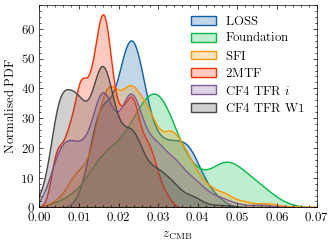

In [28]:
with plt.style.context('science'):
    plt.rcParams.update({'font.size': 9})
    plt.figure()

    sns.kdeplot(LOSS["z_CMB"], label="LOSS", fill=True, bw_adjust=0.75)
    sns.kdeplot(FOUNDATION["z_CMB"], label="Foundation", fill=True, bw_adjust=0.75)
    sns.kdeplot(SFI["z_CMB"], label="SFI", fill=True, bw_adjust=0.75)
    sns.kdeplot(TWOMTF["z_CMB"], label="2MTF", fill=True, bw_adjust=0.75)

    m = CF4_TFR["i"] > 5
    sns.kdeplot(CF4_TFR["Vcmb"][m] / SPEED_OF_LIGHT, label=catalogue_to_pretty("CF4_TFR_i"), fill=True)

    m = CF4_TFR["w1"] > 5
    sns.kdeplot(CF4_TFR["Vcmb"][m] / SPEED_OF_LIGHT, label=catalogue_to_pretty("CF4_TFR_w1"), fill=True)

    plt.xlabel(r"$z_{\rm CMB}$")
    plt.ylabel("Normalised PDF")

    plt.legend()
    plt.xlim(0, 0.07)

    plt.tight_layout()
    plt.savefig(f"../../plots/zcmb_dist.pdf", dpi=450)
    plt.show()

### 2. Sky distribution

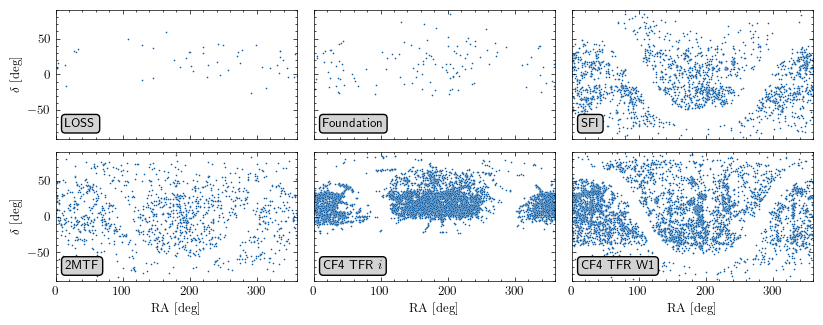

In [29]:
with plt.style.context('science'):
    plt.rcParams.update({'font.size': 9})
    figwidth = 8.3
    fig, axs = plt.subplots(2, 3, figsize=(figwidth, 0.4 * figwidth),
                            sharex=True, sharey=True)


    names = ["LOSS", "Foundation", "SFI", "2MTF", "CF4_TFR_i", "CF4_TFR_w1"]
    vals = [LOSS, FOUNDATION, SFI, TWOMTF, CF4_TFR, CF4_TFR]
    for i, ax in enumerate(axs.flat):
        RA = vals[i]["RA"]
        DEC = vals[i]["DEC"]

        if names[i] == "CF4_TFR_i":
            m = vals[i]["i"] > 5
            RA = RA[m]
            DEC = DEC[m]

        if names[i] == "CF4_TFR_w1":
            m = vals[i]["w1"] > 5
            RA = RA[m]
            DEC = DEC[m]

        sns.scatterplot(x=RA, y=DEC, ax=ax, s=1.5, rasterized=True)

        # Add panel name in top-left corner of each subplot
        ax.text(0.04, 0.16, catalogue_to_pretty(names[i]), transform=ax.transAxes, 
                fontsize=9, verticalalignment='top', 
                bbox=dict(boxstyle="round", facecolor='lightgray', alpha=1),
                zorder=10)  # Ensure text is on top of other plot elements

    axs[0, 0].set_xlim(0, 360)
    axs[0, 0].set_ylim(-90, 90)

    for i in range(3):
        axs[-1, i].set_xlabel(r"$\mathrm{RA} ~ [\mathrm{deg}]$")

    for i in range(2):
        axs[i, 0].set_ylabel(r"$\delta ~ [\mathrm{deg]}$")

    fig.tight_layout()
    plt.savefig(f"../../plots/sky_dist.pdf", dpi=350)
    fig.show()


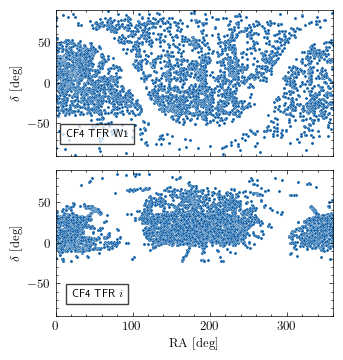

In [7]:
with plt.style.context('science'):
    plt.rcParams.update({'font.size': 9})

    RA = CF4_TFR["RA"]
    DEC = CF4_TFR["DEC"]

    fig, axs = plt.subplots(2, 1, figsize=(3.5, 1.5 * 2.45), sharex=True, sharey=True)
    fig.subplots_adjust(hspace=0.0, wspace=0.0)

    m = CF4_TFR["w1"] > 5
    sns.scatterplot(x=RA[m], y=DEC[m], s=5, rasterized=True, ax=axs[0])
    axs[0].text(0.15, 0.15, catalogue_to_pretty("CF4_TFR_w1"),
                transform=axs[0].transAxes, fontsize="small",
                verticalalignment='center', horizontalalignment='center',
                bbox=dict(facecolor='white', alpha=0.75)
                )

    m = CF4_TFR["i"] > 5
    sns.scatterplot(x=RA[m], y=DEC[m], s=5, rasterized=True, ax=axs[1])
    axs[1].text(0.15, 0.15, catalogue_to_pretty("CF4_TFR_i"),
                transform=axs[1].transAxes, fontsize="small",
                verticalalignment='center', horizontalalignment='center',
                bbox=dict(facecolor='white', alpha=0.75))

    axs[0].set_xlim(0, 360)
    axs[0].set_ylim(-90, 90)

    for i in range(2):
        axs[i].set_ylabel(r"$\delta ~ [\mathrm{deg}]$")
    axs[-1].set_xlabel(r"$\mathrm{RA} ~ [\mathrm{deg}]$")

    fig.tight_layout()
    fig.savefig(f"../../plots/sky_dist_CF4.pdf", dpi=350)
    fig.show()

## Experimenting

In [21]:
l, b = radec_to_galactic(CF4_TFR["RA"], CF4_TFR["DE"])
# l, b = radec_to_galactic(SFI["RA"], SFI["DEC"])

In [22]:
np.abs(b).min()

0.06692355049302931

In [26]:
(np.abs(b) < 10).sum()

232

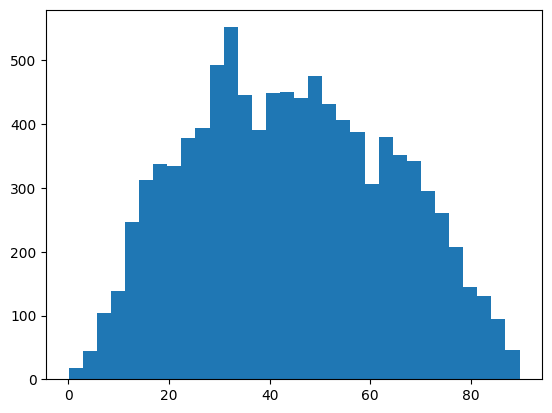

In [23]:
plt.figure()
plt.hist(np.abs(b), bins="auto")
plt.show()

In [17]:
with File("/mnt/extraspace/rstiskalek/catalogs/PV_compilation.hdf5", 'r') as f:
    print(f["SFI_gals"].keys())

    zCMB_sfi = f["SFI_gals"]["z_CMB"][...]
    mag_sfi = f["SFI_gals"]["mag"][...]
    eta_sfi = f["SFI_gals"]["eta"][...]
    e_mag_sfi = f["SFI_gals"]["e_mag"][...]
    e_eta_sfi = f["SFI_gals"]["e_eta"][...]

    zCMB_2MTF = f["2MTF"]["z_CMB"][...]
    mag_2MTF = f["2MTF"]["mag"][...]
    eta_2MTF = f["2MTF"]["eta"][...]
    e_mag_2MTF = f["2MTF"]["e_mag"][...]
    e_eta_2MTF = f["2MTF"]["e_eta"][...]

<KeysViewHDF5 ['DEC', 'RA', 'e_eta', 'e_mag', 'eta', 'mag', 'z_CMB']>


In [28]:
with File("/mnt/extraspace/rstiskalek/catalogs/PV/CF4/CF4_TF-distances.hdf5", 'r') as f:
    zCMB = f["Vcmb"][...] / 3e5
    rband = f["r"][...]
    iband = f["i"][...]
    w1band = f["w1"][...]
    RA = f["RA"][...] * 360 / 24
    dec = f["DE"][...]

# m  = (iband > 5) #& (w1band > 5)
m  = (w1band> 5) #& (w1band > 5)
w1band = w1band[m]
iband = iband[m]
RA = RA[m]
dec = dec[m]

In [29]:
dmag = iband - w1band

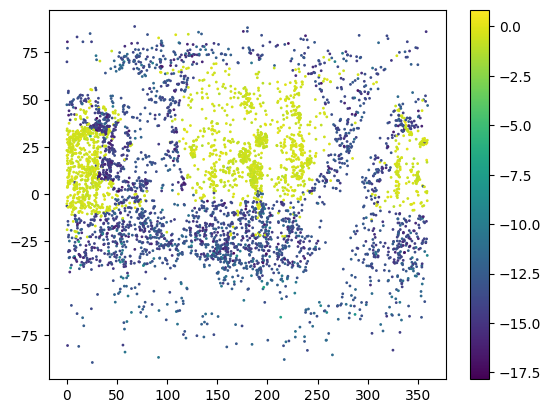

In [30]:
plt.figure()
plt.scatter(RA, dec, c=dmag, s=1)
plt.colorbar()
plt.show()

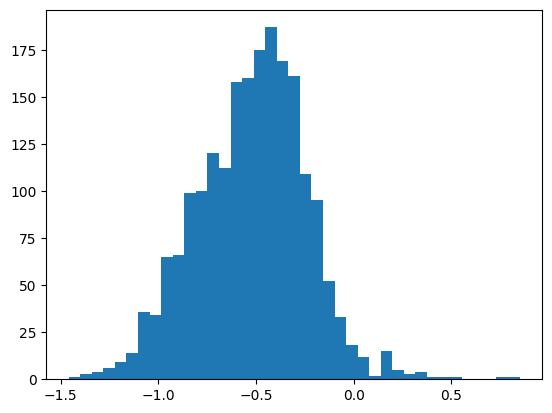

In [11]:
plt.figure()
plt.hist(iband - w1band, bins="auto")
plt.show()

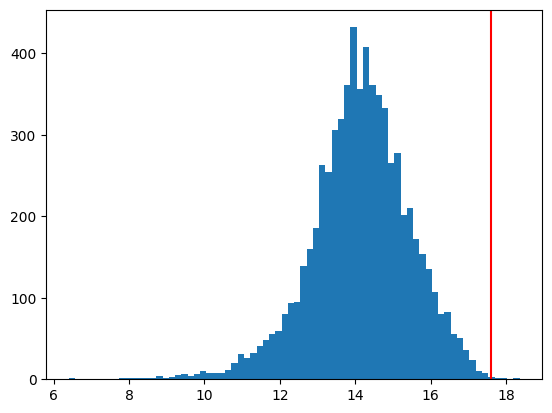

In [69]:
m = rband > 0

plt.figure()
plt.hist(rband[m], bins="auto")
plt.axvline(17.6, c="red")
plt.show()

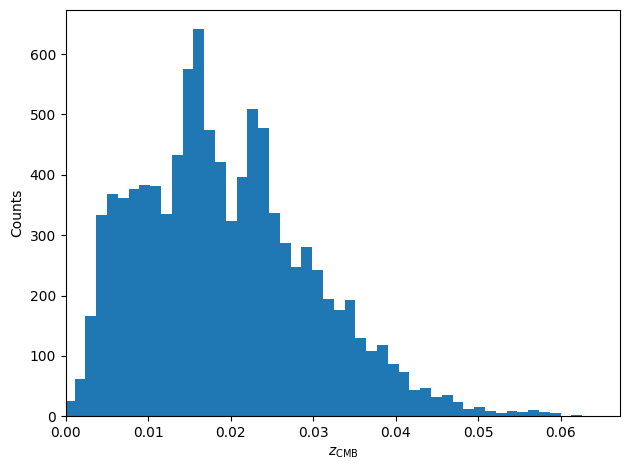

In [64]:
plt.figure()
plt.hist(zCMB, bins="auto")
plt.xlabel(r"$z_{\rm CMB}$")
plt.ylabel("Counts")
plt.xlim(0)
plt.tight_layout()
plt.savefig("../../plots/zCMB_CF4.png")
plt.show()

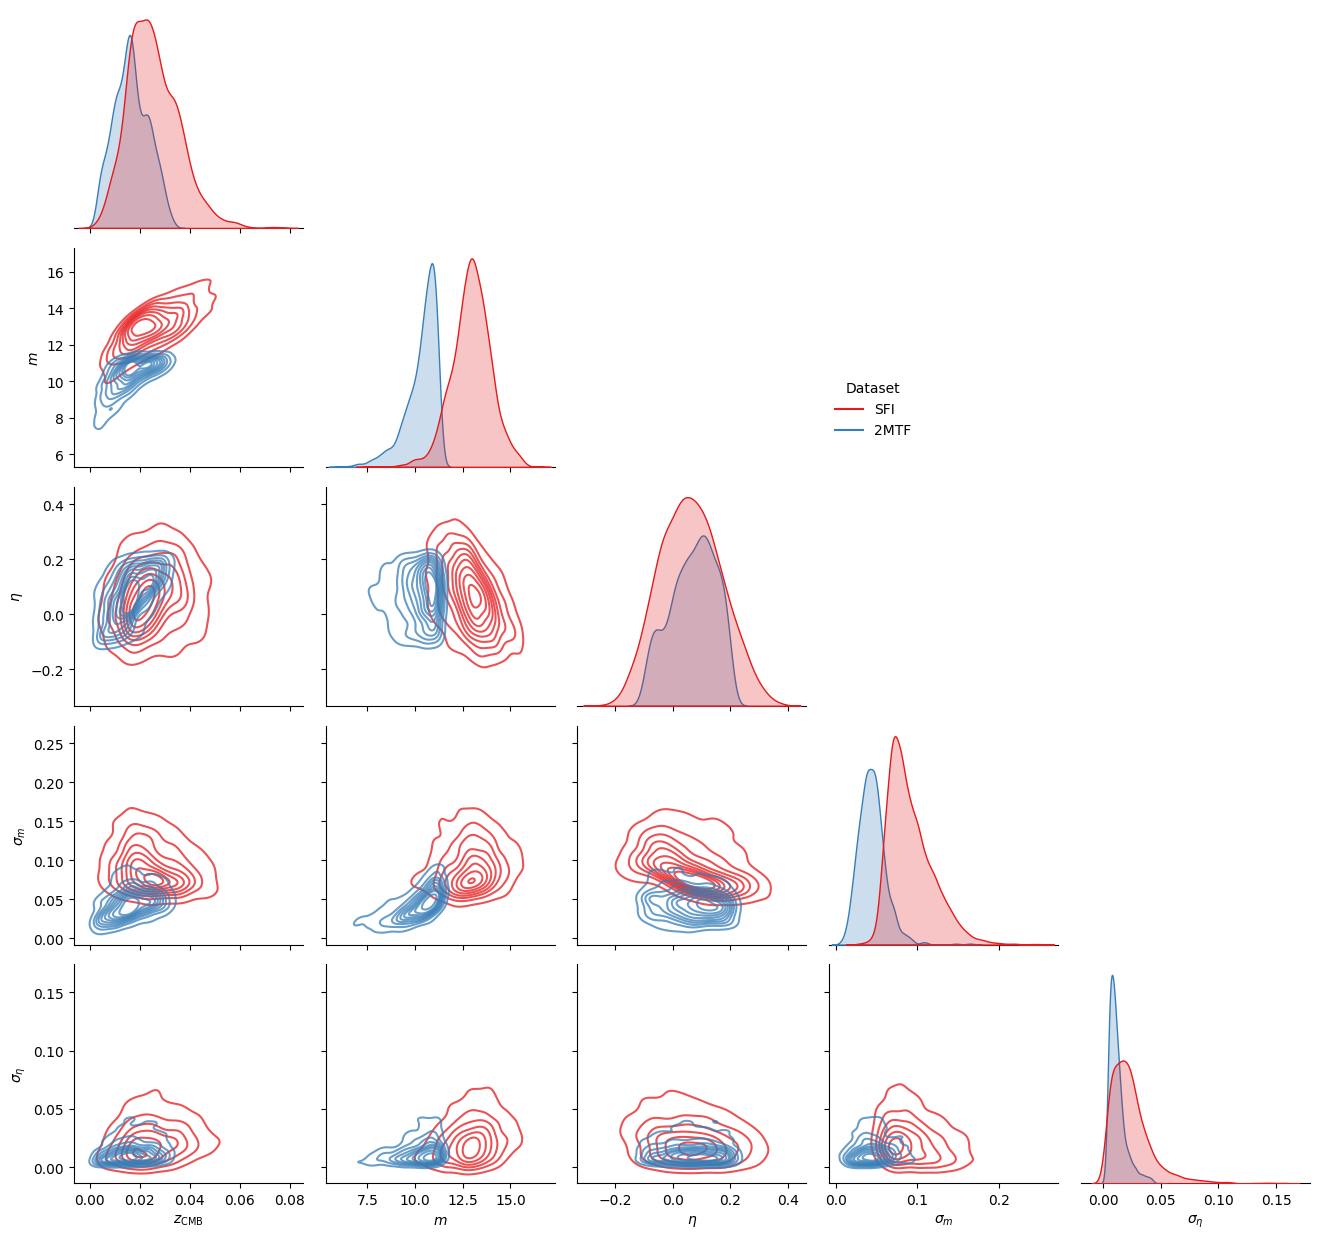

In [53]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

df_sfi = pd.DataFrame({
    r"$z_{\rm CMB}$": zCMB_sfi,
    r"$m$": mag_sfi,
    r"$\eta$": eta_sfi,
    r"$\sigma_{m}$": e_mag_sfi,
    r"$\sigma_\eta$": e_eta_sfi,
    "Dataset": "SFI"
})

df_2mtf = pd.DataFrame({
    r"$z_{\rm CMB}$": zCMB_2MTF,
    r"$m$": mag_2MTF,
    r"$\eta$": eta_2MTF,
    r"$\sigma_{m}$": e_mag_2MTF,
    r"$\sigma_\eta$": e_eta_2MTF,
    "Dataset": "2MTF"
})

df_combined = pd.concat([df_sfi, df_2mtf])
g = sns.pairplot(df_combined, hue="Dataset", kind="kde", diag_kind="kde",
             palette="Set1", corner=True, plot_kws={"alpha": 0.75},
             diag_kws={"fill": True})
sns.move_legend(g, "upper right", bbox_to_anchor=(0.7, 0.7))

# Show the plot
plt.tight_layout()
plt.savefig("../../plots/TFR_data.pdf", dpi=450)
plt.show()
